# Dataset Creation and Augmentation

In [1]:
import os
from pathlib import Path

import cv2 as cv
import random
import matplotlib.pyplot as plt
import albumentations as A

C:\Users\matou\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Create Dataset from Video

In [8]:
VIDEO_DIR = Path("../data/video_source/")  # Input videos folder
OUTPUT_DIR = Path("../data/classification_dataset/")      # Root output folder
TRAIN_SPLIT = 0.8                          # 80% of frames → train, 20% → val
RESIZE_WIDTH = 256                         # Final image width
RESIZE_HEIGHT = 256                        # Final image height
FRAME_SKIP = 1                             # Extract every N-th frame (1 = every frame)

TRAIN_DIR = OUTPUT_DIR / "train"
VAL_DIR = OUTPUT_DIR / "val"

TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VAL_DIR.mkdir(parents=True, exist_ok=True)


video_files = [f for f in VIDEO_DIR.iterdir() if f.suffix.lower() in [".mp4", ".avi", ".mov", ".mkv"]]
if not video_files:
    raise FileNotFoundError(f"No video files found in {VIDEO_DIR}")

print(f"Found {len(video_files)} video files in {VIDEO_DIR}")

image_id = 0
all_saved_days = set()
for video_path in video_files:
    # Determine class from filename (0.* or 1.*)
    try:
        video_class = int(video_path.stem.split('.')[0])  # class = first part before "."
    except ValueError:
        raise ValueError(f"Video filename must start with class label (e.g., '0.myvideo.mp4'). Got: {video_path.name}")

    print(f"Processing {video_path.name} (class {video_class})")

    cap = cv.VideoCapture(str(video_path))
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Skip frames if needed
        if frame_count % FRAME_SKIP != 0:
            frame_count += 1
            continue

        # Resize frame
        frame_resized = cv.resize(frame, (RESIZE_WIDTH, RESIZE_HEIGHT), interpolation=cv.INTER_AREA)

        # Decide whether frame goes to train or val
        if random.random() < TRAIN_SPLIT:
            save_dir = TRAIN_DIR
        else:
            save_dir = VAL_DIR

        # Filename: image_<id>_<class>.jpg
        filename = f"image_{image_id}_{video_class}.jpg"
        save_path = save_dir / filename

        cv.imwrite(str(save_path), frame_resized)
        image_id += 1
        frame_count += 1

    cap.release()

print(f"Processing complete. Total frames saved: {image_id}")
print(f"Train folder: {len(list(TRAIN_DIR.glob('*.jpg')))} images")
print(f"Val folder: {len(list(VAL_DIR.glob('*.jpg')))} images")

Found 2 video files in ..\data\video_source
Processing 0.mp4 (class 0)
Processing 1.mp4 (class 1)
Processing complete. Total frames saved: 123
Train folder: 101 images
Val folder: 22 images


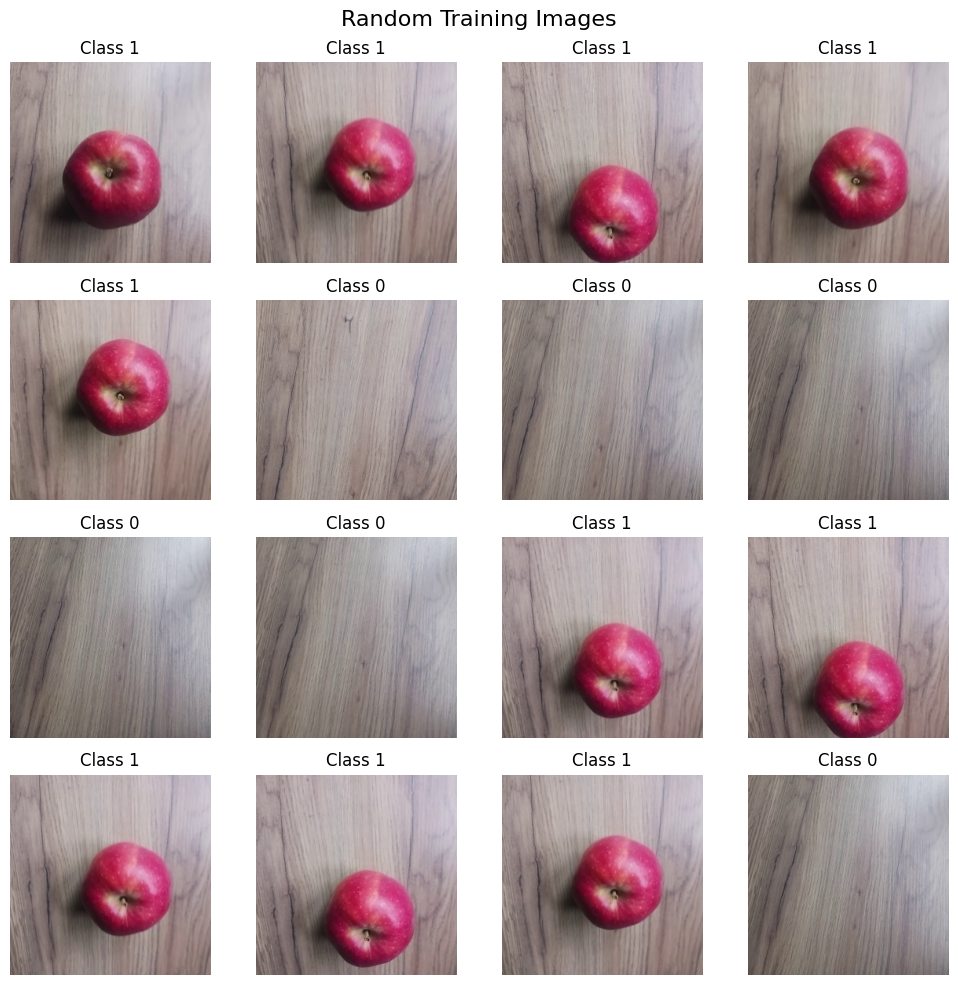

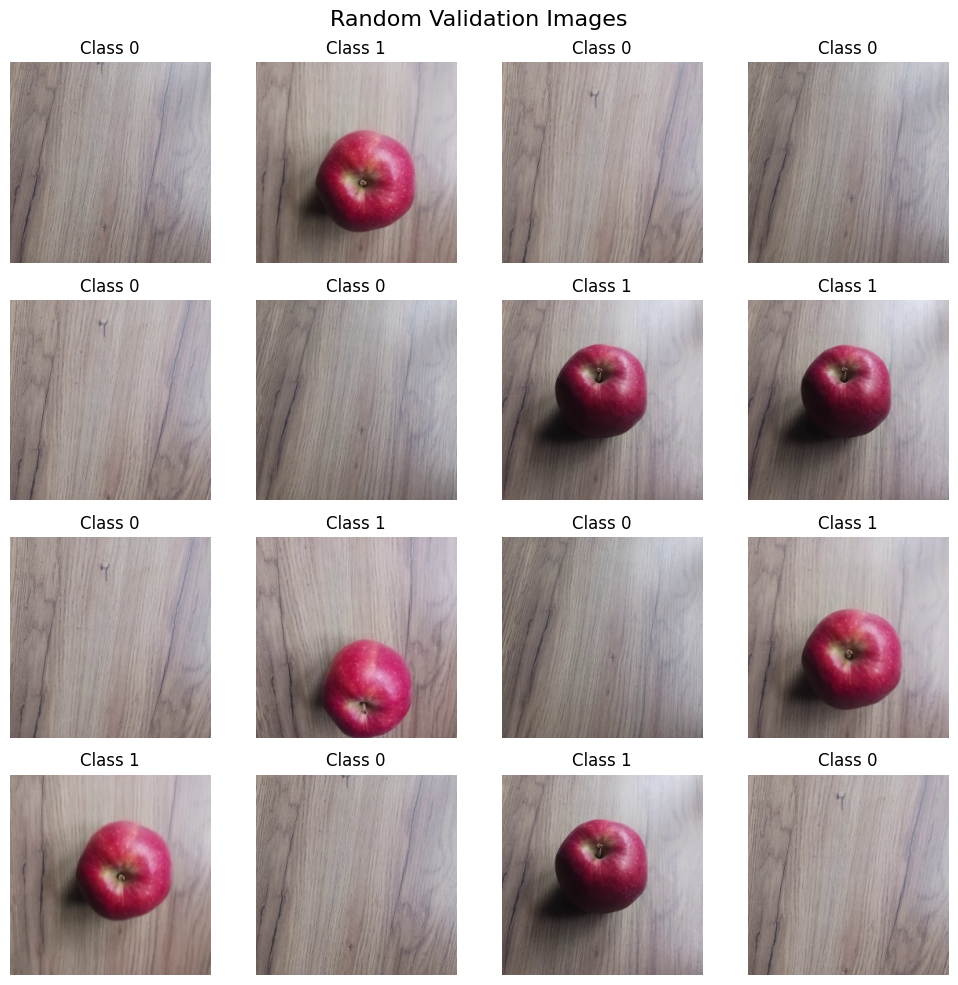

In [9]:
GRID_SIZE = 4          # 4x4 grid
IMG_SIZE = (RESIZE_WIDTH, RESIZE_HEIGHT)  # Resize for display

def show_random_images(folder: Path, title: str, grid_size: int = 4):
    files = list(folder.glob("*.jpg"))
    if len(files) < grid_size * grid_size:
        raise ValueError(f"Not enough images in {folder} to display {grid_size*grid_size} samples. Found: {len(files)}")

    # Pick random files
    selected_files = random.sample(files, grid_size * grid_size)

    # Create figure
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)

    for ax, img_path in zip(axes.flatten(), selected_files):
        # Load and convert BGR to RGB
        img = cv.imread(str(img_path))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Optional resize for consistent display
        img = cv.resize(img, IMG_SIZE)

        # Extract class label from filename (image_<id>_<class>.jpg)
        class_label = img_path.stem.split("_")[-1]

        ax.imshow(img)
        ax.set_title(f"Class {class_label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(TRAIN_DIR, "Random Training Images", GRID_SIZE)
show_random_images(VAL_DIR, "Random Validation Images", GRID_SIZE)

## Augmentation

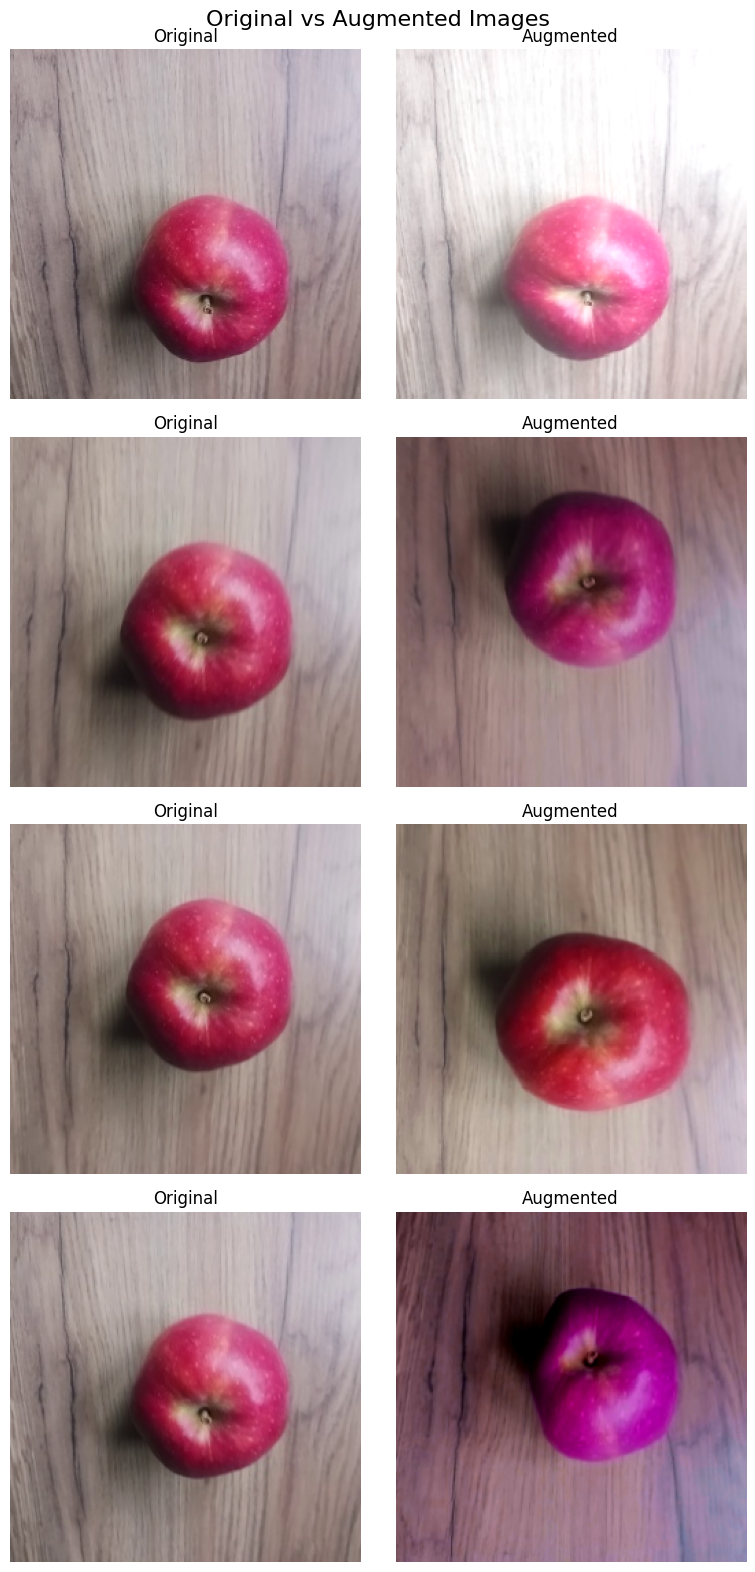

In [4]:
NUM_IMAGES = 4                              # Number of random images to augment

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),             # 50% chance of horizontal flip
    A.VerticalFlip(p=0.2),               # 20% chance of vertical flip
    
    A.GridDistortion(num_steps=8, distort_limit=0.3, p=1.0),

    A.HueSaturationValue(
        hue_shift_limit=30,            # Hue shift ±20
        sat_shift_limit=50,            # Saturation ±30
        val_shift_limit=30,            # Brightness (value) ±20
        p=0.8
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.5
    ),
    
    # --- Final resize to ensure consistency ---
    A.Resize(height=IMG_SIZE[1], width=IMG_SIZE[0])
])


def load_random_images(folder: Path, count: int):
    files = list(folder.glob("*.jpg"))
    if len(files) < count:
        raise ValueError(f"Not enough images in {folder} to load {count} samples. Found: {len(files)}")
    return random.sample(files, count)

random_images = load_random_images(TRAIN_DIR, NUM_IMAGES)

fig, axes = plt.subplots(NUM_IMAGES, 2, figsize=(8, NUM_IMAGES * 4))
fig.suptitle("Original vs Augmented Images", fontsize=16)

for idx, img_path in enumerate(random_images):
    # Load image
    img = cv.imread(str(img_path))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, IMG_SIZE)

    # Apply augmentation
    augmented = augmentation_pipeline(image=img)["image"]

    # Display original
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title("Original")
    axes[idx, 0].axis("off")

    # Display augmented
    axes[idx, 1].imshow(augmented)
    axes[idx, 1].set_title("Augmented")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()